## Langgraph Chain
Review
We built a simple graph with nodes, normal edges, and conditional edges.

Goals
Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state
Using chat models in graph nodes
Binding tools to our chat model
Executing tool calls in graph nodes

In [3]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [4]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()
llm = ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CBEC49E900>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CBEC49F4D0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
llm.invoke(messages)

AIMessage(content="You're in for a treat! Orcas, also known as killer whales, are magnificent creatures. \n\n**The Pacific Northwest is renowned for its incredible orca viewing opportunities.**  Here are some of the best spots:\n\n* **San Juan Islands, Washington:** This archipelago is considered a prime orca watching destination.  \n    * **Why?** The islands lie within the orcas' migration routes and feeding grounds. \n    * **Where?**  Popular spots include Friday Harbor, Lopez Island, and Orcas Island.\n    * **Tip:**  Many whale watching tours operate from here, offering the best chance to see these majestic animals.\n\n* **Whidbey Island, Washington:**\n    * **Why?**  Whidbey Island offers a more secluded and less crowded option for orca viewing compared to the San Juans.\n    * **Where?**  Look out for orcas near Deception Pass and the southern end of the island.\n    * **Tip:**  Consider renting a kayak or taking a boat tour.\n\n* **Southern California:**\n    * **Why?** Altho

In [ ]:
def add(a:int, b:int)->int:
    """
    Add a and b
    Args:
        a: First integer
        b: Second integer    
    """
    return a + b
    
llm_with_tools = llm.bind_tools([add])
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CBEC49E900>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CBEC49F4D0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b\nArgs:\n    a: First integer\n    b: Second integer    ', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ghyfztmtr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 981, 'total_tokens': 1066, 'completion_time': 0.154545455, 'prompt_time': 0.034272993, 'queue_time': 0.24342309599999998, 'total_time': 0.188818448}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--59ba8788-363f-40c5-8b82-a46028d74616-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'ghyfztmtr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 981, 'output_tokens': 85, 'total_tokens': 1066})

In [10]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'ghyfztmtr',
  'type': 'tool_call'}]

In [16]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, AIMessage
from langgraph.graph import add_messages

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [17]:
initial_message=[
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on generative ai.", name="Arya")
]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")
add_messages(initial_message, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='b56668fd-39ad-49e3-9162-21aa5cc0bf42'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Arya', id='bad67ff0-9b03-4fb2-9694-6ca1d1ff1e5c'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='75109528-6b4d-4cac-ae61-ca3dc460fb6c')]

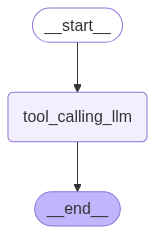

In [27]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END, MessagesState

def tool_calling_llm(state: MessagesState):
    return { "messages": [llm.invoke(state["messages"])]}

# Build Graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
messages=graph.invoke({"messages":HumanMessage(content="What is 10 plus 30")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 10 plus 30
================================== Ai Message ==================================

10 plus 30 equals 40.


### Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.
When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.
And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.
You can simply pass any Python function into ChatModel.bind_tools(function).

In [29]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [24]:
llm_with_tools = llm.bind_tools([add, multiply])
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CBEC49E900>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CBEC49F4D0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b\nArgs:\n    a: First integer\n    b: Second integer    ', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

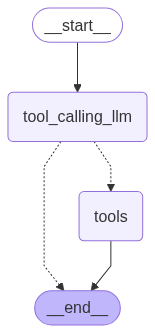

In [30]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state=MessagesState):
    return { "messages": [llm_with_tools.invoke(state["messages"])]}

# Build Graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([add, multiply]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2 and add 5.")]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2 and add 5.
================================== Ai Message ==================================
Tool Calls:
  add (2jm5e9pay)
 Call ID: 2jm5e9pay
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7


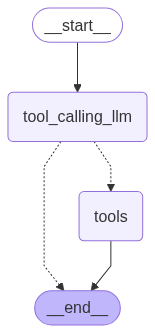

In [ ]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from IPython.display import display, Image
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END

# Load environment variables
load_dotenv()

# Define tool functions
def add(a:int, b:int) -> int:
    """Add a and b
    Args:
        a: first integer number
        b: second integer number
    Return:
        Sum of a and b
    """
    return a + b

def multiply(a:int, b:int) -> int:
    """Multiply a and b
    Args:
        a: first intger number
        b: second intger number
    Return:
        Multication of a and b
    """
    return a * b

def divide(a:int, b:int) -> float:
    """Divide a by b
    Args:
        a: first intger number
        b: second intger number
    """
    return a / b

# Define Gemm2 model
llm = ChatGroq(model="gemma2-9b-it")
llm.invoke("What is Generative AI?")

# Bind tools with LLM
llm_with_tools = llm.bind_tools([add, multiply])

# Define state
def tool_calling_llm(state: MessagesState):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

# Build Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode([add, multiply]))

# Connect node edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    tools_condition    
)
builder.add_edge('tools', END)

# Compile graph builder
graph = builder.compile()

# Display workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Then the result multiply by 5 and add 15.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then the result multiply by 5 and add 15.
================================== Ai Message ==================================
Tool Calls:
  add (zq63ccxw6)
 Call ID: zq63ccxw6
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7


### LLM with Tools

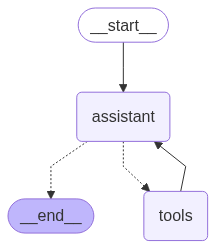

In [26]:
from dotenv import load_dotenv
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, SystemMessage
from langgraph.graph import add_messages
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END

# Load environment variables
load_dotenv()

# Define tool functions
def add(a:int, b:int) -> int:
    """Add a and b
    Args:
        a: first integer number
        b: second integer number
    Return:
        Sum of a and b
    """
    return a + b

def multiply(a:int, b:int) -> int:
    """Multiply a and b
    Args:
        a: first intger number
        b: second intger number
    Return:
        Multication of a and b
    """
    return a * b

def divide(a:int, b:int) -> float:
    """Divide a by b
    Args:
        a: first intger number
        b: second intger number
    """
    return a / b

# Define Gemm2 model
# llm = ChatGroq(model="gemma2-9b-it")
llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatGroq(model='llama-3.1-8b-instant')
llm.invoke("What is Generative AI?")

# Bind tools with LLM
llm_with_tools = llm.bind_tools([add, multiply], parallel_tool_calls=False)

# System message
system_message = SystemMessage(content='You are a helpful assistant tasked with performing arithmetic on a set of inputs.')

# Define state
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    
def assistant(state: MessageState):
    return {'messages': [llm_with_tools.invoke([system_message] + state['messages'])]}

# Build Graph
builder = StateGraph(MessagesState)

builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode([add, multiply, divide]))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition
)
builder.add_edge('tools', 'assistant')

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Then the result multiply by 5 and add 15. Then divide the result by 10.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then the result multiply by 5 and add 15. Then divide the result by 10.
================================== Ai Message ==================================
Tool Calls:
  add (call_2xDiBTn5viDDKAN62LLYAvB9)
 Call ID: call_2xDiBTn5viDDKAN62LLYAvB9
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bGguplfyVIrV4ZYr3WE2e7gf)
 Call ID: call_bGguplfyVIrV4ZYr3WE2e7gf
  Args:
    a: 7
    b: 5
================================= Tool Message =================================
Name: multiply

35
================================== Ai Message ==================================
Tool Calls:
  add (call_vg0CEY6k3e5G57ouz9sHeRbw)
 Call ID: call_vg0CEY6k3e5G57ouz9sHeRbw
  Args:
    a: 35
    b: 15
================================= Tool Me

## Memory in Agents Using MemoryServer

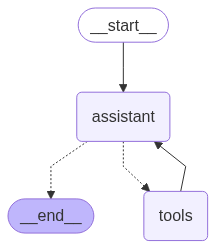

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

react_graph = builder.compile(checkpointer=memory)
react_graph

In [30]:
config = {'configurable': {'thread_id': '1'}}

messages = [HumanMessage(content='Add 3 and 4')]

messages = react_graph.invoke({'messages': messages}, config)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_mYMttKsgbDhU78lDVDh0Z1be)
 Call ID: call_mYMttKsgbDhU78lDVDh0Z1be
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [31]:
messages = [HumanMessage(content='Multiply by 2')]

messages = react_graph.invoke({'messages': messages}, config)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_mYMttKsgbDhU78lDVDh0Z1be)
 Call ID: call_mYMttKsgbDhU78lDVDh0Z1be
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_r5PLOQZ7HkdmF1VsUg6bcS9X)
 Call ID: call_r5PLOQZ7HkdmF1VsUg6bcS9X
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multiplying 7 